In [1]:
import numpy as np 
import zipfile
import io
import pretty_midi
import os
import pandas as pd 
import tensorflow as tf 
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, LabelEncoder
from collections import Counter
import tempfile
import pygame
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


pygame 2.6.1 (SDL 2.28.4, Python 3.12.1)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def extract_features(notes, tempo, num_instruments, split, composer, filename):
    if not notes:
        return None

    notes.sort(key=lambda n: n.start)

    chunk_duration = notes[-1].end - notes[0].start
    pitches = [n.pitch for n in notes]
    durations = [n.end - n.start for n in notes]
    velocities = [n.velocity for n in notes]
    onsets = [round(n.start, 3) for n in notes]  # rounded for grouping

    # Polyphony analysis: map onset → notes starting at that time
    onset_counts = Counter(onsets)
    chord_sizes = list(onset_counts.values())

    avg_chord_size = np.mean(chord_sizes) if chord_sizes else 0
    chord_density = len(onset_counts) / chunk_duration if chunk_duration > 0 else 0

    note_count = len(notes)
    avg_pitch = np.mean(pitches)
    pitch_range = max(pitches) - min(pitches)
    std_pitch = np.std(pitches)
    most_common_pitch = Counter(pitches).most_common(1)[0][0]

    avg_duration = np.mean(durations)
    std_duration = np.std(durations)
    note_density = note_count / chunk_duration if chunk_duration > 0 else 0
    velocity_mean = np.mean(velocities)
    velocity_std = np.std(velocities)

    return {
        'split': split,
        'composer': composer,
        'filename': filename,
        'tempo': tempo,
        'num_instruments': num_instruments,
        'duration': chunk_duration,
        'note_count': note_count,
        'avg_pitch': avg_pitch,
        'pitch_range': pitch_range,
        'std_pitch': std_pitch,
        'most_common_pitch': most_common_pitch,
        'avg_duration': avg_duration,
        'std_duration': std_duration,
        'note_density': note_density,
        'velocity_mean': velocity_mean,
        'velocity_std': velocity_std,
        'avg_chord_size': avg_chord_size,
        'chord_density': chord_density
    }

In [3]:
def chunk_notes(notes, chunk_size=200):
    """Split list of notes into chunks of size `chunk_size`."""
    return [notes[i:i + chunk_size] for i in range(0, len(notes), chunk_size) if len(notes[i:i + chunk_size]) == chunk_size]

In [4]:
def process_zip_to_chunks(zip_path, chunk_size=200):
    data = []

    with zipfile.ZipFile(zip_path, 'r') as archive:
        for file in archive.namelist():
            if (
                file.endswith('.mid') or file.endswith('.midi')
            ) and '__MACOSX' not in file and not os.path.basename(file).startswith('._'):

                parts = file.split('/')
                if len(parts) >= 5:
                    split = parts[2]
                    composer = parts[3]
                    filename = parts[-1]

                    with archive.open(file) as midi_file:
                        try:
                            midi_bytes = midi_file.read()
                            midi_data = pretty_midi.PrettyMIDI(io.BytesIO(midi_bytes))

                            tempo = midi_data.estimate_tempo()
                            num_instruments = len(midi_data.instruments)

                            notes = []
                            for instrument in midi_data.instruments:
                                if not instrument.is_drum:
                                    notes.extend(instrument.notes)

                            notes.sort(key=lambda n: n.start)
                            note_chunks = chunk_notes(notes, chunk_size=chunk_size)

                            for chunk in note_chunks:
                                features = extract_features(chunk, tempo, num_instruments, split, composer, filename)
                                if features:
                                    data.append(features)

                        except Exception as e:
                            print(f"Error reading {file}: {e}")

    return pd.DataFrame(data)

In [5]:
zip_path = 'Composer_Dataset.zip'
df_augmented = process_zip_to_chunks(zip_path, chunk_size=200)

print(df_augmented.head())
print(f"\nTotal samples (augmented): {len(df_augmented)}")
print("\nCount by split:")
print(df_augmented['split'].value_counts())
print("\nCount by composer:")
print(df_augmented['composer'].value_counts())

/Users/swathi/.pyenv/versions/3.12.1/lib/python3.12/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


  split composer       filename       tempo  num_instruments   duration  \
0  test   mozart  mozart014.mid  164.921515                6  58.563971   
1  test   mozart  mozart014.mid  164.921515                6  45.148796   
2  test   mozart  mozart014.mid  164.921515                6  44.516356   
3  test   mozart  mozart014.mid  164.921515                6  22.499993   
4  test   mozart  mozart014.mid  164.921515                6  29.397313   

   note_count  avg_pitch  pitch_range  std_pitch  most_common_pitch  \
0         200     61.960           45  10.106849                 57   
1         200     64.055           41   9.802141                 73   
2         200     63.385           43   9.934625                 52   
3         200     65.885           44  12.524048                 52   
4         200     64.695           55  11.828862                 52   

   avg_duration  std_duration  note_density  velocity_mean  velocity_std  \
0      0.656957      0.527952      3.415069   

In [6]:
df_augmented.shape

(8338, 18)

In [7]:
label_encoder = LabelEncoder()
df_augmented['label'] = label_encoder.fit_transform(df_augmented['composer'])

In [8]:
# Choose a row from the augmented DataFrame
row_id = 12  # You can change this
target_file = df_augmented.iloc[row_id]['filename']
target_split = df_augmented.iloc[row_id]['split']
target_composer = df_augmented.iloc[row_id]['composer']

# Rebuild full path inside ZIP
target_path_in_zip = f'Composer_Dataset/NN_midi_files_extended/{target_split}/{target_composer}/{target_file}'

# Extract and save the MIDI file to a temporary location
zip_path = 'Composer_Dataset.zip'
with zipfile.ZipFile(zip_path, 'r') as archive:
    with archive.open(target_path_in_zip) as midi_file:
        with tempfile.NamedTemporaryFile(delete=False, suffix='.mid') as temp_midi:
            temp_midi.write(midi_file.read())
            temp_midi_path = temp_midi.name

# Initialize Pygame Mixer
pygame.init()
pygame.mixer.init()
pygame.mixer.music.load(temp_midi_path)

print(f"\n🎵 Selected MIDI: {target_file} by {target_composer} [{target_split}]")
print("Controls: [p]lay | [s]top | [r]esume | [q]uit\n")

while True:
    cmd = input("Enter command: ").strip().lower()

    if cmd == 'p':
        pygame.mixer.music.play()
    elif cmd == 's':
        pygame.mixer.music.pause()
    elif cmd == 'r':
        pygame.mixer.music.unpause()
    elif cmd == 'q':
        pygame.mixer.music.stop()
        print("🎵 Exiting player.")
        break
    else:
        print("Invalid command. Use [p]lay, [s]top, [r]esume, [q]uit.")


🎵 Selected MIDI: mozart038.mid by mozart [test]
Controls: [p]lay | [s]top | [r]esume | [q]uit

🎵 Exiting player.


### Split the dataset

In [10]:
df_augmented.isnull().sum()

split                0
composer             0
filename             0
tempo                0
num_instruments      0
duration             0
note_count           0
avg_pitch            0
pitch_range          0
std_pitch            0
most_common_pitch    0
avg_duration         0
std_duration         0
note_density         0
velocity_mean        0
velocity_std         0
avg_chord_size       0
chord_density        0
label                0
dtype: int64

In [11]:
# Separate by split column
train_df = df_augmented[df_augmented['split'] == 'train'].reset_index(drop=True)
val_df   = df_augmented[df_augmented['split'] == 'dev'].reset_index(drop=True)
test_df  = df_augmented[df_augmented['split'] == 'test'].reset_index(drop=True)

In [12]:
train_df.shape

(7196, 19)

In [14]:
test_df.shape

(605, 19)

In [15]:
val_df.shape

(537, 19)

In [16]:
drop_cols = ['split', 'composer', 'filename']

# Training data
X_train = train_df.drop(columns=drop_cols + ['label'])
y_train = train_df['label']

# Validation data
X_val = val_df.drop(columns=drop_cols + ['label'])
y_val = val_df['label']

# Test data
X_test = test_df.drop(columns=drop_cols + ['label'])
y_test = test_df['label']

In [17]:
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

X_train: (7196, 15) y_train: (7196,)
X_val: (537, 15) y_val: (537,)
X_test: (605, 15) y_test: (605,)


### Apply StandardScaling

In [18]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit on training set, transform all sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

In [19]:
# Reshape input for LSTM: (samples, timesteps, features)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_lstm = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [20]:
# One-hot encode labels
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [21]:
# Build LSTM model
model = Sequential([
    Input(shape=(1, X_train_scaled.shape[1])), 
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [22]:
from tensorflow.keras.optimizers import Adam
learning_rate = 0.001  
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_lstm, y_train_cat,
    epochs=30,
    batch_size=32,
    validation_data=(X_val_lstm, y_val_cat),
    verbose=1
)

Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3106 - loss: 2.0144 - val_accuracy: 0.4823 - val_loss: 1.3730
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.5830 - loss: 1.1710 - val_accuracy: 0.5698 - val_loss: 1.1229
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.6518 - loss: 0.9433 - val_accuracy: 0.5903 - val_loss: 1.0686
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - accuracy: 0.6874 - loss: 0.8573 - val_accuracy: 0.6034 - val_loss: 1.0001
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - accuracy: 0.7023 - loss: 0.8098 - val_accuracy: 0.5698 - val_loss: 1.0137
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - accuracy: 0.7201 - loss: 0.7308 - val_accuracy: 0.6145 - val_loss: 0.9884
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - accuracy: 0.7344 - loss: 0.7297 - val_accuracy: 0.6015 - val_loss: 0.9932
Epoch 8/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.7389 - loss: 0.6849 - va

In [23]:
# Evaluate
test_loss, test_acc = model.evaluate(X_test_lstm, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.7124


In [24]:
# Predict
y_pred = np.argmax(model.predict(X_test_lstm), axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [25]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.89      0.79        56
           1       0.71      0.14      0.24        35
           2       0.81      1.00      0.89        25
           3       0.66      0.92      0.77        48
           4       0.97      0.84      0.90        75
           5       0.62      0.85      0.71       136
           6       0.84      0.41      0.55        99
           7       0.80      0.74      0.77        91
           8       0.47      0.53      0.49        40

    accuracy                           0.71       605
   macro avg       0.73      0.70      0.68       605
weighted avg       0.74      0.71      0.69       605



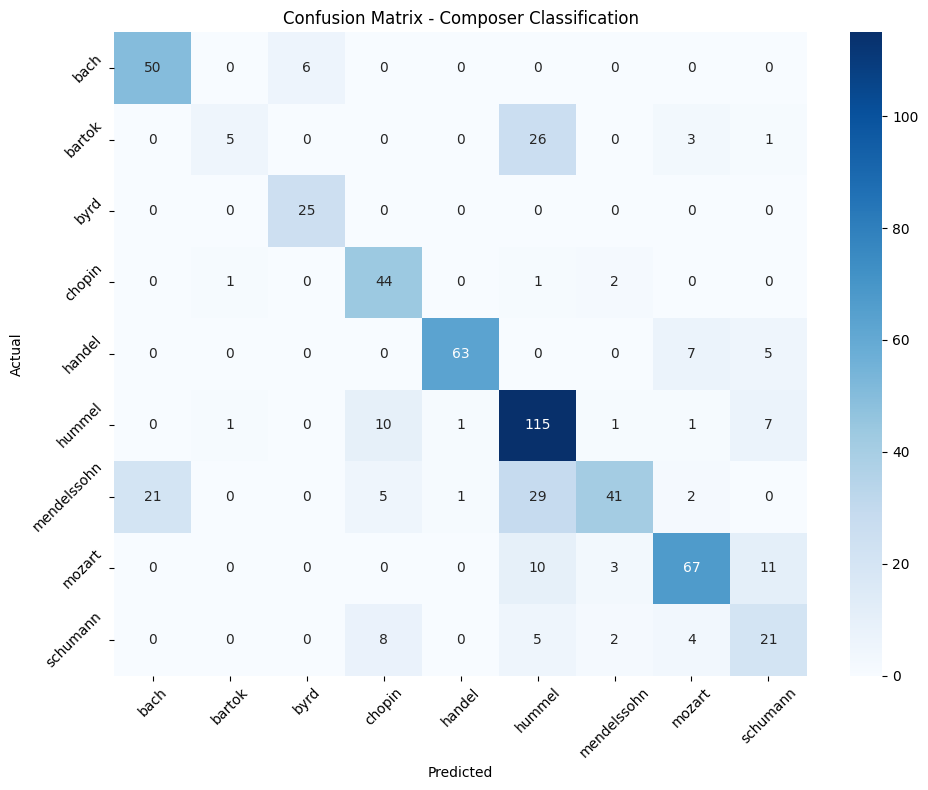

In [26]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
class_names = label_encoder.classes_

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Composer Classification')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

### Wanted to perform grid search here to implement using LSTM for multi classification task

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

# Example search space
learning_rates = [0.001, 0.0005]
lstm_units = [32, 64]
dropout_rates = [0.3, 0.5]

best_acc = 0
best_params = {}

for lr in learning_rates:
    for units in lstm_units:
        for drop in dropout_rates:
            print(f"\nTraining model with lr={lr}, lstm_units={units}, dropout={drop}")
            
            model = Sequential([
                Input(shape=(1, X_train_scaled.shape[1])),  # First layer defines input shape
                LSTM(units, return_sequences=True),
                Dropout(drop),
                LSTM(units // 2),
                Dropout(drop),
                Dense(32, activation='relu'),
                Dense(num_classes, activation='softmax')
            ])
            
            optimizer = Adam(learning_rate=lr)
            model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

            model.fit(
                X_train_lstm, y_train_cat,
                epochs=100,  # use fewer epochs for faster tuning
                batch_size=32,
                validation_data=(X_val_lstm, y_val_cat),
                verbose=0
            )

            y_val_pred = np.argmax(model.predict(X_val_lstm), axis=1)
            acc = accuracy_score(y_val, y_val_pred)

            print(f"Validation Accuracy: {acc:.4f}")
            if acc > best_acc:
                best_acc = acc
                best_params = {'lr': lr, 'units': units, 'dropout': drop}

print("\nBest Hyperparameters:")
print(best_params)
print(f"Best Validation Accuracy: {best_acc:.4f}")


Training model with lr=0.001, lstm_units=32, dropout=0.3
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Validation Accuracy: 0.6145

Training model with lr=0.001, lstm_units=32, dropout=0.5
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Validation Accuracy: 0.5754

Training model with lr=0.001, lstm_units=64, dropout=0.3
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Validation Accuracy: 0.6034

Training model with lr=0.001, lstm_units=64, dropout=0.5
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Validation Accuracy: 0.6127

Training model with lr=0.0005, lstm_units=32, dropout=0.3
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Validation Accuracy: 0.6406

Training model with lr=0.0005, lstm_units=32, dropout=0.5
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Validation Accuracy: 0.6108

Training model with lr=0.0005, lstm_units=64, dropout=0.3
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Validation Accuracy: 0.6108

Training model with lr=0.0005, lstm_units=64, dropout=0.5
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Validation Accuracy: 0.

### Implementation of CNN Classification

CNNs typically expect 2D or 3D shaped input. For 1D feature vectors, we’ll reshape them into a pseudo “image” format. A common choice is reshaping to (features, 1, 1) or treating features as channels.

In [29]:
# Import all necessary libraries for CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, Dense, Input

In [30]:
# Prepare data for CNN
# Reshape to (samples, features, 1)
X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_val_cnn   = X_val_scaled.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))
X_test_cnn  = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

In [ ]:
# Build CNN Model
cnn_model = Sequential([
    Input(shape=(X_train_scaled.shape[1], 1)),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

In [32]:
# Compile and Train the Model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_cnn = cnn_model.fit(
    X_train_cnn, y_train_cat,
    epochs=30,
    batch_size=32,
    validation_data=(X_val_cnn, y_val_cat),
    verbose=1
)

Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step - accuracy: 0.1966 - loss: 2.0998 - val_accuracy: 0.3985 - val_loss: 1.6931
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - accuracy: 0.3607 - loss: 1.6867 - val_accuracy: 0.4916 - val_loss: 1.3837
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - accuracy: 0.4673 - loss: 1.4133 - val_accuracy: 0.6425 - val_loss: 1.2124
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - accuracy: 0.5195 - loss: 1.2930 - val_accuracy: 0.6276 - val_loss: 1.1446
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - accuracy: 0.5570 - loss: 1.2125 - val_accuracy: 0.6238 - val_loss: 1.0725
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.5753 - loss: 1.1744 - val_accuracy: 0.5922 - val_loss: 1.0271
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.5879 - loss: 1.1348 - val_accuracy: 0.6034 - val_loss: 0.9998
Epoch 8/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - accuracy: 0.6004 - loss: 1.1026 - 

In [33]:
# Evaluate and predict
test_loss, test_acc = cnn_model.evaluate(X_test_cnn, y_test_cat, verbose=0)
print(f"Test Accuracy (CNN): {test_acc:.4f}")

# Predict
y_pred_cnn = np.argmax(cnn_model.predict(X_test_cnn), axis=1)

# Classification report
print(classification_report(y_test, y_pred_cnn))

Test Accuracy (CNN): 0.7405
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

           0       0.71      0.84      0.77        56
           1       0.50      0.03      0.05        35
           2       0.74      1.00      0.85        25
           3       0.63      0.79      0.70        48
           4       0.95      0.72      0.82        75
           5       0.72      0.91      0.81       136
           6       0.96      0.56      0.71        99
           7       0.77      0.88      0.82        91
           8       0.45      0.60      0.52        40

    accuracy                           0.74       605
   macro avg       0.72      0.70      0.67       605
weighted avg       0.76      0.74      0.72       605



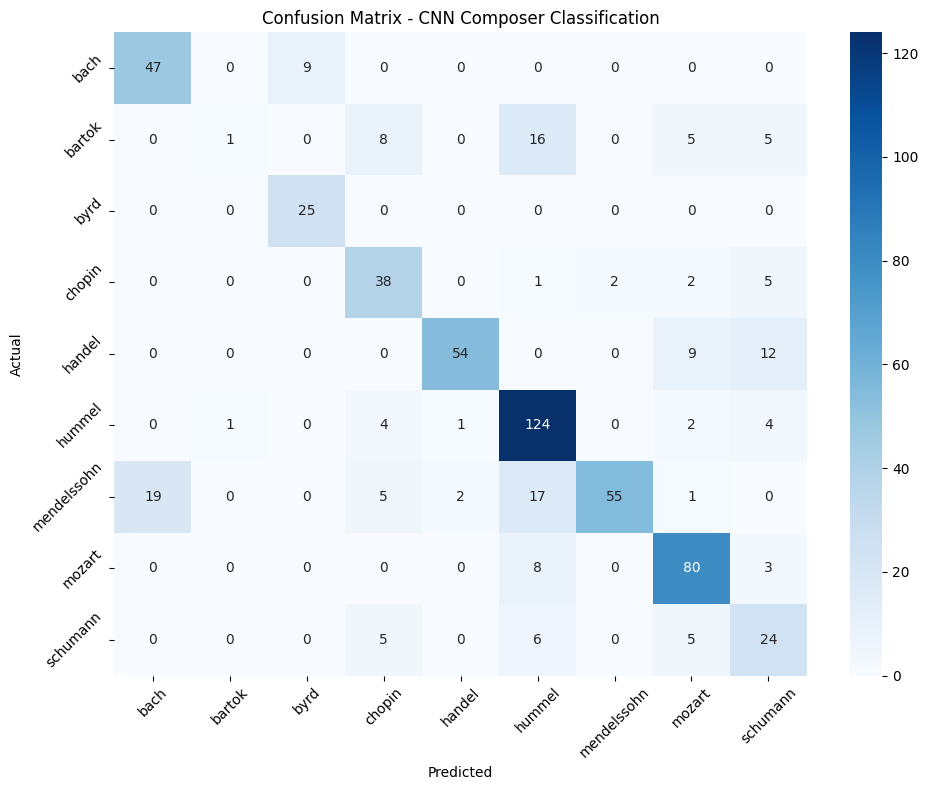

In [34]:
cm_cnn = confusion_matrix(y_test, y_pred_cnn)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - CNN Composer Classification')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

### CNN-LSTM hybrid ensemble model implementation

CNN layers help in learning local patterns (e.g., pitch/duration/velocity structures) across feature dimensions.

LSTM layers learn temporal dependencies and sequential relationships within note sequences or feature trends.

Model Architecture Plan (CNN + LSTM Hybrid)

1.	Reshape input to 2D to apply Conv1D across features.
2.	Apply Conv1D + MaxPooling to extract feature patterns.
3.	Feed output to LSTM for sequential understanding.
4.	Dense layers for final classification.

In [35]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [36]:
# Reshape inputs: (samples, 1, features) → (samples, features, 1)
X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_val_cnn = X_val_scaled.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

input_shape = (X_train_cnn.shape[1], X_train_cnn.shape[2])
num_classes = len(np.unique(y_train))

In [45]:
# Build the hybrid model
inputs = Input(shape=input_shape)

x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

x = LSTM(64, return_sequences=False)(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

model3 = Model(inputs=inputs, outputs=x)

# Compile the model
optimizer = Adam(learning_rate=0.01)
model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model3.fit(
    X_train_cnn, y_train_cat,
    epochs=100,
    batch_size=64,
    validation_data=(X_val_cnn, y_val_cat),
    verbose=1
)

Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3378 - loss: 1.7176 - val_accuracy: 0.6499 - val_loss: 0.9454
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6169 - loss: 1.0256 - val_accuracy: 0.6071 - val_loss: 1.0849
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6737 - loss: 0.8772 - val_accuracy: 0.5307 - val_loss: 1.1471
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7062 - loss: 0.8058 - val_accuracy: 0.5568 - val_loss: 1.1581
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7370 - loss: 0.7220 - val_accuracy: 0.5512 - val_loss: 1.1277
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7637 - loss: 0.6508 - val_accuracy: 0.5549 - val_loss: 1.5468
Epoch 7/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7846 - loss: 0.6059 - val_accuracy: 0.5754 - val_loss: 1.5473
Epoch 8/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7966 - loss: 0.5711 - val_accu


🎯 Test Accuracy: 0.6744
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.82      0.75        56
           1       0.31      0.14      0.20        35
           2       0.71      1.00      0.83        25
           3       0.66      0.77      0.71        48
           4       0.72      0.61      0.66        75
           5       0.77      0.85      0.80       136
           6       0.85      0.41      0.56        99
           7       0.61      0.77      0.68        91
           8       0.43      0.57      0.49        40

    accuracy                           0.67       605
   macro avg       0.64      0.66      0.63       605
weighted avg       0.68      0.67      0.66       605



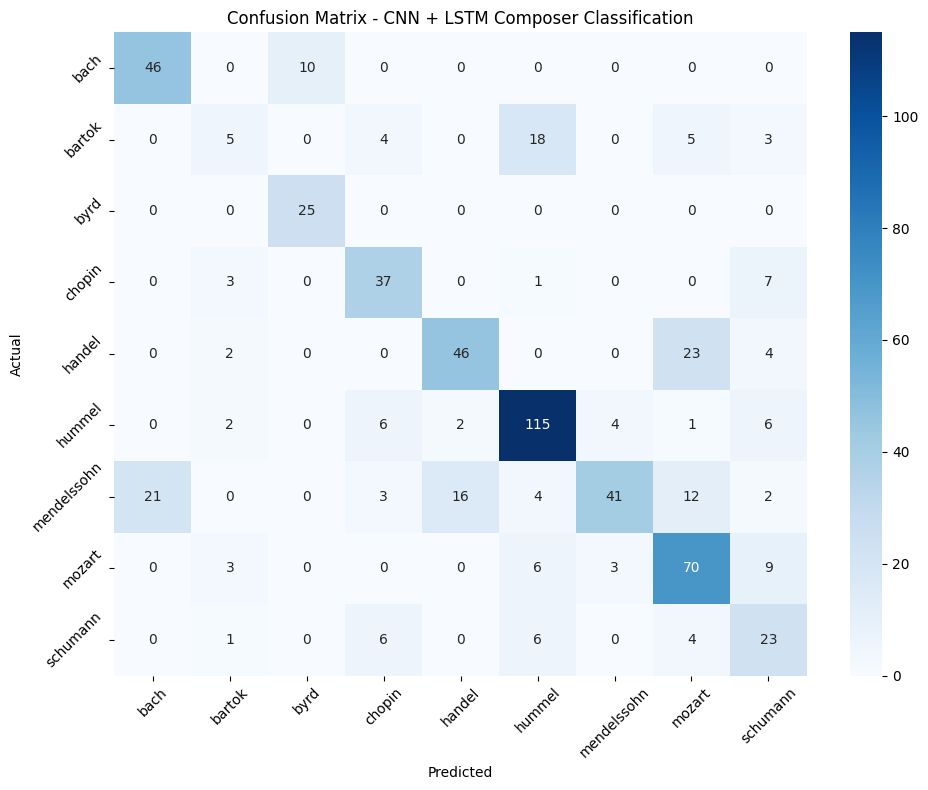

: 

In [ ]:
# Evaluate
test_loss, test_acc = model.evaluate(X_test_cnn, y_test_cat, verbose=0)
print(f"\n🎯 Test Accuracy: {test_acc:.4f}")

# Predict
y_pred = np.argmax(model.predict(X_test_cnn), axis=1)

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
class_names = label_encoder.classes_

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - CNN + LSTM Composer Classification')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()